In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

### Define two-site binding model with two microscopic affinities k1,k2 and cooperativity factor f

In [2]:
class SSB:

    def __init__(self,k1=1e7,k2=1e8,f=10):
        self.k1 = k1
        self.k2 = k2
        self.f = f
        self.conc_range = (-12,-3)
        self.binding_curve = []
        self.xvals = []
        self.step = .01
        self.step_func = lambda x: 10**x

        self.function = lambda x: (k1*x + k2*x + f*2*k1*k2*x**2) / (2 * (1 + k1*x + k2*x + f*k1*k2*x**2))

    def sim(self):
        self.binding_curve = []
        self.xvals = []
        for val in np.arange(self.conc_range[0],self.conc_range[1],self.step):
            if self.step_func:
                self.xvals.append(self.step_func(val))
                self.binding_curve.append(self.function(self.step_func(val)))
            else:
                self.xvals.append(val)
                self.binding_curve.append(self.function(val))

#### Run function and plot binding curve

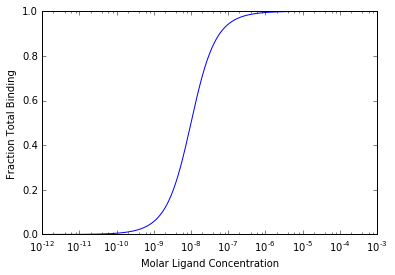

In [34]:
ssb = SSB()
ssb.sim()
plt.plot(ssb.xvals,ssb.binding_curve)
plt.xscale("log")

plt.xlabel("Molar Ligand Concentration")
plt.ylabel("Fraction Total Binding")

### Genetic algorithm
- Holds a population (size N) of SSB models
- Two main functions: procreate and select
- Procreate creates a new population of size N. New models have all 3 parameters disturbed by a Brownian motion process
- Select draws a new population of size N from old population with probabilities proportional to normalized fitness against the target binding model

In [4]:
class PhysPopulation(SSB):
    
    def __init__(self,N=100,selection_strength=10,k1=1e7,k2=1e8,f=10):
        
        # Biophysical model
        # Create target model on startup by simulating under binding model and populating self.binding curve
        SSB.__init__(self,k1,k2,f)
        self.sim() # get starting curve
        self.target = self.binding_curve
        self.mean_k1 = 0
        self.mean_k2 = 0
        self.mean_f = 0
        self.var_k1 = 0
        self.var_k2 = 0
        self.var_f = 0
        
        # Population parameters
        self.population = []
        self.mean_fitness = 0
        self.fitness_var = 0
        
        # Genetic algorithm params
        self.N = N
        self.selection_strength = selection_strength
        self.cost_function = self._distance_function
        self._initialize_pop()
        
        # Brownian motion params
        self.dt = 10
        
    def _update_biophys_params(self,sim=False):
        '''Update means and variances for population K1 and K2s'''
        k1s,k2s,fs = [],[],[]
        for i in self.population:
            if sim:
                i.sim()
            k1s.append(i.k1)
            k2s.append(i.k2)
            fs.append(i.f)
        self.mean_k1 = sum(k1s)/len(k1s)
        self.mean_k2 = sum(k2s)/len(k2s)
        self.mean_f = sum(fs)/len(fs)
        self.var_k1 = np.var(k1s)
        self.var_k2 = np.var(k2s)
        self.var_f = np.var(fs)
        
    def _initialize_pop(self,K_lower=1e5,K_upper=1e9,f_lower=0,f_upper=100):
        '''Create starting population of size self.N filled with Adair models, each sampled'''
        rando = np.random.uniform
        self.population = [SSB(rando(K_lower,K_upper),
                               rando(K_lower,K_upper),
                                rando(f_lower,f_upper)) for i in range(self.N)]
        self._update_biophys_params()
        
    def _distance_function(self,target,comp):
        '''Compute abs(x-y) between two input binding curves'''
        assert len(comp) == len(target)
        return sum(map(lambda (x,y): abs(x-y), zip(target,comp)))
    
    def _pop_fitness(self):
        fitness_vec = [self.selection_strength*(1/self.cost_function(m.binding_curve,self.target))
                       for m in self.population]
        self.mean_fitness = sum(fitness_vec)/len(fitness_vec)
        self.fitness_var = np.var(fitness_vec)
        return fitness_vec
    
    def brownian(self,params=[]):
        '''Take a single brownian step over params vector'''
        out = []
        for i in params:
            new_param = i + norm.rvs(loc=0,scale=2*self.dt)
            if new_param < 0:
                new_param = 0
            out.append(new_param)
        return out
        
    def procreate(self):
        new_pop = []
        for model in self.population:
            new_k1,new_k2,new_f = self.brownian([model.k1,model.k2,model.f])
            model = SSB(new_k1,new_k2,new_f)
            model.sim() # create new binding curve
            new_pop.append(model)
        self.population = new_pop
        self._update_biophys_params(sim=False)
        
    def select(self):
        fitness_vec = self._pop_fitness()
        w_sum = sum(fitness_vec)
        w_norm = [i/w_sum for i in fitness_vec]
        new_pop = np.random.choice(self.population,self.N,p=w_norm)
        self.population = new_pop
        self._update_biophys_params(sim=False)

#### 100 rounds of selection

In [19]:
pop1 = PhysPopulation(N=100)

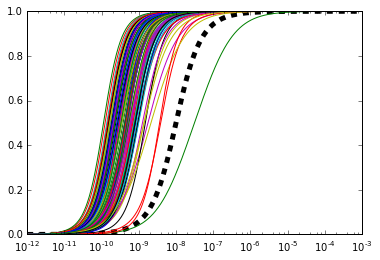

In [20]:
## Plot initial population of curves.

plt.plot()

plt.plot(pop1.xvals, pop1.target,"k--",lw=5)

for i in pop1.population:
    i.sim()
    plt.plot(i.xvals,i.binding_curve)
    
plt.xscale("log")

In [21]:
# Select for 100 generations
# Store mean fitness, fitness variance, and parameter variances

w1 = []
w1_var = []
k1_var1 = []
k2_var1 = []
f_var1 = []
for i in range(100):
    pop1.select()
    w1.append(pop1.mean_fitness)
    w1_var.append(pop1.fitness_var)
    k1_var1.append(pop1.var_k1)
    k2_var1.append(pop1.var_k2)
    f_var1.append(pop1.var_f)

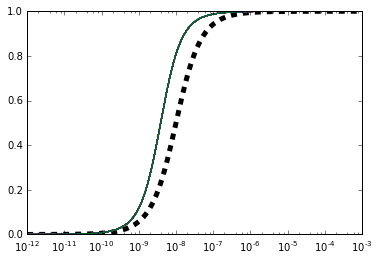

In [22]:
# Plot population after selection

plt.plot(pop1.xvals, pop1.target,"k--",lw=5)

for i in pop1.population:
    i.sim()
    plt.plot(i.xvals, i.binding_curve)

plt.xscale("log")

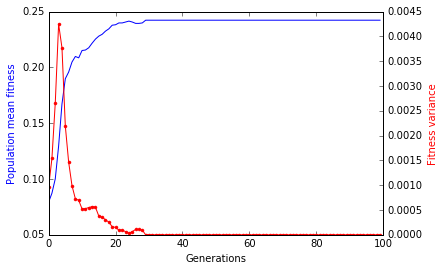

In [23]:
# Plot fitness mean and variance over generations

fig,ax1 = plt.subplots()
ax1.plot(w1,"b")
ax1.set_ylabel("Population mean fitness",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(w1_var,"r.-")
ax2.set_ylabel("Fitness variance",color="red")

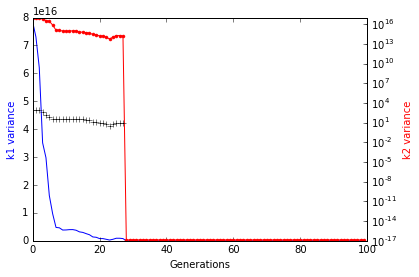

In [24]:
# Plot parameter variances: k1,k2,f

fig,ax1 = plt.subplots()
ax1.plot(k1_var1,"b")
ax1.set_ylabel("k1 variance",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(k2_var1,"r.-")
ax2.set_ylabel("k2 variance",color="red")

ax2.plot(f_var1,"k+")
plt.yscale("log")

## New population - 100 rounds of mutation/selection

In [62]:
pop2 = PhysPopulation(N=100)

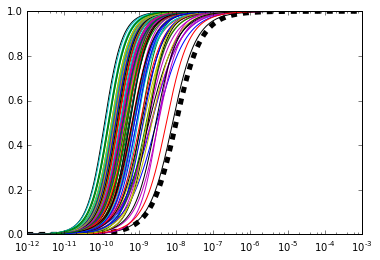

In [55]:
plt.plot()

plt.plot(pop2.xvals, pop2.target,"k--",lw=5)

for i in pop2.population:
    i.sim()
    plt.plot(i.xvals, i.binding_curve)

plt.xscale("log")

In [56]:
# Select/mutate for 500 generations

w2 = []
w2_var = []
k1_var2 = []
k2_var2 = []
f_var2 = []
for i in range(500):
    pop2.procreate()
    pop2.select()
    w2.append(pop2.mean_fitness)
    w2_var.append(pop2.fitness_var)
    k1_var2.append(pop2.var_k1)
    k2_var2.append(pop2.var_k2)
    f_var2.append(pop2.var_f)
    

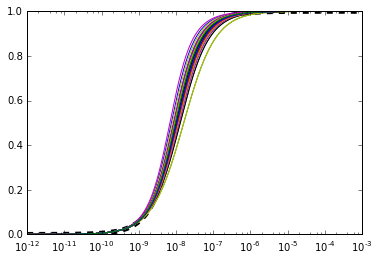

In [57]:
# Plot
plt.plot()

plt.plot(pop2.xvals, pop2.target,"k--",lw=5)

for i in pop2.population:
    i.sim()
    plt.plot(i.xvals, i.binding_curve)
    
plt.xscale("log")

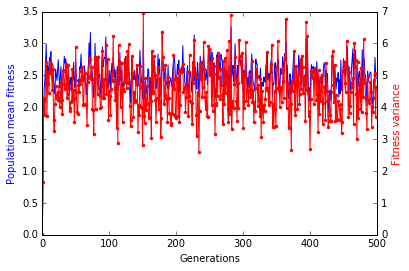

In [58]:
fig,ax1 = plt.subplots()
ax1.plot(w2,"b")
ax1.set_ylabel("Population mean fitness",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(w2_var,"r.-")
ax2.set_ylabel("Fitness variance",color="red")

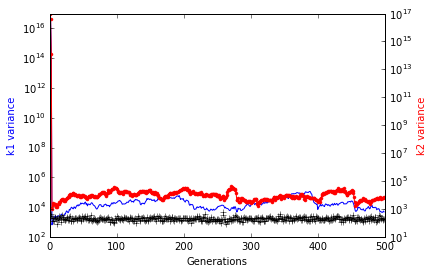

In [59]:
fig,ax1 = plt.subplots()
ax1.plot(k1_var2,"b")
ax1.set_ylabel("k1 variance",color="blue")
ax1.set_xlabel("Generations")
plt.yscale("log")

ax2 = ax1.twinx()
ax2.plot(k2_var2,"r.-")
ax2.set_ylabel("k2 variance",color="red")

ax2.plot(f_var2,"k+")

plt.yscale("log")

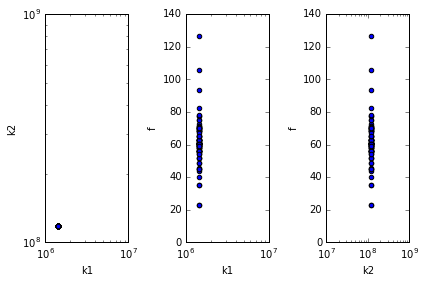

In [60]:
k1s = [ind.k1 for ind in pop2.population]
k2s = [ind.k2 for ind in pop2.population]
fs = [ind.f for ind in pop2.population]

df = pd.DataFrame({"k1":k1s,"k2":k2s,"f":fs})

fig, axes = plt.subplots(1,3)

df.plot(ax=axes.flat[0],kind="scatter",x="k1",y="k2",logx=True,logy=True)
df.plot(ax=axes.flat[1],kind="scatter",x="k1",y="f",logx=True,logy=False)
df.plot(ax=axes.flat[2],kind="scatter",x="k2",y="f",logx=True,logy=False)
                   
plt.tight_layout()

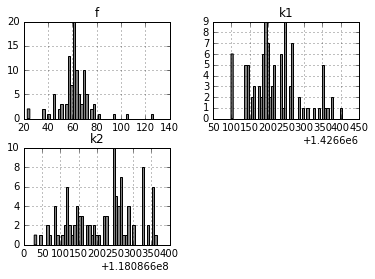

In [61]:
axes = df.hist(bins=50,color='grey')

### Reduced selection strength

In [88]:
pop3 = PhysPopulation(N=100,selection_strength=.1)

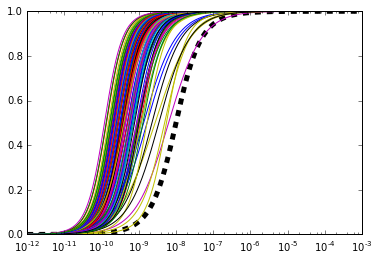

In [89]:
plt.plot()

plt.plot(pop3.xvals, pop3.target,"k--",lw=5)

for i in pop3.population:
    i.sim()
    plt.plot(i.xvals, i.binding_curve)

plt.xscale("log")

In [90]:
# Select/mutate for 100 generations

w3 = []
w3_var = []
k1_var3 = []
k2_var3 = []
f_var3 = []
for i in range(100):
    pop3.procreate()
    pop3.select()
    w3.append(pop3.mean_fitness)
    w3_var.append(pop3.fitness_var)
    k1_var3.append(pop3.var_k1)
    k2_var3.append(pop3.var_k2)
    f_var3.append(pop3.var_f)

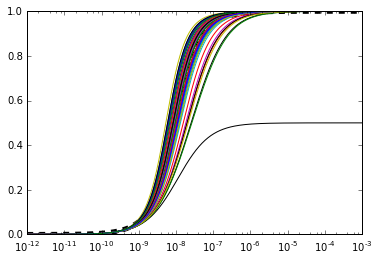

In [91]:
plt.plot()

plt.plot(pop3.xvals, pop3.target,"k--",lw=5)

for i in pop3.population:
    i.sim()
    plt.plot(i.xvals, i.binding_curve)

plt.xscale("log")

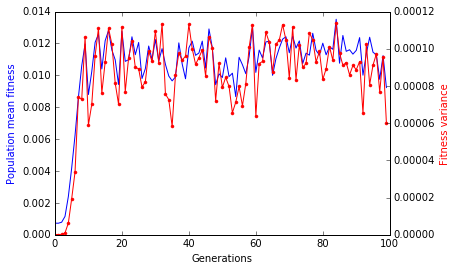

In [92]:
fig,ax1 = plt.subplots()
ax1.plot(w3,"b")
ax1.set_ylabel("Population mean fitness",color="blue")
ax1.set_xlabel("Generations")

ax2 = ax1.twinx()
ax2.plot(w3_var,"r.-")
ax2.set_ylabel("Fitness variance",color="red")

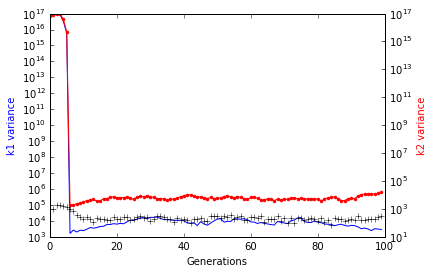

In [93]:
fig,ax1 = plt.subplots()
ax1.plot(k1_var3,"b")
ax1.set_ylabel("k1 variance",color="blue")
ax1.set_xlabel("Generations")
plt.yscale("log")

ax2 = ax1.twinx()
ax2.plot(k2_var3,"r.-")
ax2.set_ylabel("k2 variance",color="red")

ax2.plot(f_var3,"k+")

plt.yscale("log")

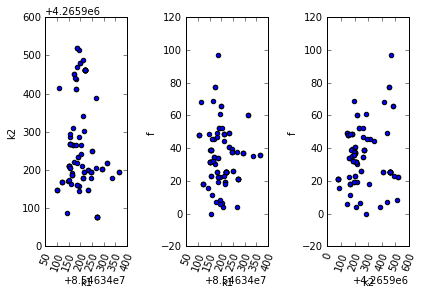

In [98]:
k1s = [ind.k1 for ind in pop3.population]
k2s = [ind.k2 for ind in pop3.population]
fs = [ind.f for ind in pop3.population]

df = pd.DataFrame({"k1":k1s,"k2":k2s,"f":fs})

fig, axes = plt.subplots(1,3)

df.plot(ax=axes.flat[0],kind="scatter",x="k1",y="k2")
df.plot(ax=axes.flat[1],kind="scatter",x="k1",y="f")
df.plot(ax=axes.flat[2],kind="scatter",x="k2",y="f")
                   
plt.tight_layout()

for a in axes.flat:
    for t in a.get_xticklabels():
        t.set_rotation(70)

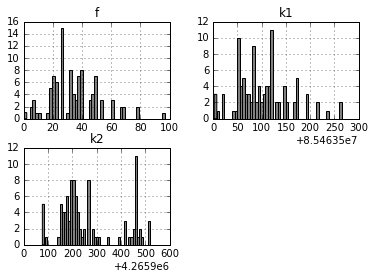

In [99]:
axes = df.hist(bins=50,color='grey')

In [100]:
set(k1s)

{85463502.20470603,
 85463510.76789953,
 85463520.34711178,
 85463542.37711011,
 85463548.80721253,
 85463552.2882843,
 85463553.68522716,
 85463554.18118005,
 85463556.20585312,
 85463557.45772578,
 85463558.09440058,
 85463561.54023255,
 85463563.9549287,
 85463564.3794,
 85463568.3217288,
 85463568.34380327,
 85463571.22549821,
 85463572.89213437,
 85463578.46156657,
 85463579.66335185,
 85463581.4795944,
 85463582.45851938,
 85463584.30827488,
 85463584.3961761,
 85463584.77964585,
 85463585.04662885,
 85463590.62385054,
 85463593.68791153,
 85463594.28992432,
 85463594.49910659,
 85463595.46376123,
 85463599.25609954,
 85463604.51630647,
 85463605.19069624,
 85463606.4223159,
 85463611.26328288,
 85463611.86120184,
 85463613.62302217,
 85463614.66857655,
 85463616.08913405,
 85463620.35732794,
 85463632.3514382,
 85463633.9950425,
 85463644.90766342,
 85463645.84777406,
 85463652.08804335,
 85463667.61983967,
 85463668.11269914,
 85463670.57215407,
 85463692.32650293,
 85463715.21